In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
EPOCHS = 30
BATCH_SIZE = 128
MODEL_DIR = "model_files"
os.makedirs(MODEL_DIR, exist_ok=True)

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
print("Training set:", x_train.shape, y_train.shape)
print("Test set:", x_test.shape, y_test.shape)
class_names = [
'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training set: (60000, 28, 28) (60000,)
Test set: (10000, 28, 28) (10000,)


In [4]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
# Expand dims if you want channels: (28,28) -> (28,28,1) — helpful for ConvNets
x_train = np.expand_dims(x_train, -1) # shape becomes (N, 28, 28, 1)
x_test = np.expand_dims(x_test, -1)
# One-hot encode labels for Keras (categorical_crossentropy)
num_classes = 10
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

In [6]:
def show_sample_grid(images, labels, class_names, rows=3, cols=6):
    fig, axes = plt.subplots(rows, cols, figsize=(cols*1.6, rows*1.6))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.set_title(class_names[labels[i]])
        ax.axis('off')
    plt.tight_layout()

In [8]:
def build_dense_model(input_shape=(28,28,1), num_classes=10):
    model = keras.Sequential([
    layers.Input(shape=input_shape),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
    ], name='dense_mnist_model')
    return model

In [10]:
def build_conv_model(input_shape=(28,28,1), num_classes=10):
    model = keras.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
    ], name='conv_mnist_model')
    return model

In [12]:
use_conv = True
if use_conv:
    model = build_conv_model()
else:
    model = build_dense_model()


model.summary()

Model: "conv_mnist_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 422,154 (1.61 MB)

 Trainable params: 421,898 (1.61 MB)

 Non-trainable params: 256 (1.00 KB)

In [13]:
model.compile(
optimizer=keras.optimizers.Adam(learning_rate=1e-3),
loss='categorical_crossentropy',
metrics=['accuracy']
)

In [14]:
checkpoint_path = os.path.join(MODEL_DIR, 'best_model.h5')
callbacks = [
keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True, monitor='val_loss'),
keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss')
]

In [15]:
history = model.fit(
x_train, y_train_cat,
validation_split=0.1, # keep 10% of training for validation
epochs=EPOCHS,
batch_size=BATCH_SIZE,
callbacks=callbacks,
verbose=2
)

Epoch 1/30


422/422 - 54s - 128ms/step - accuracy: 0.8494 - loss: 0.4322 - val_accuracy: 0.8797 - val_loss: 0.3819
Epoch 2/30


422/422 - 60s - 142ms/step - accuracy: 0.9003 - loss: 0.2861 - val_accuracy: 0.9023 - val_loss: 0.2690
Epoch 3/30
422/422 - 53s - 126ms/step - accuracy: 0.9111 - loss: 0.2474 - val_accuracy: 0.9012 - val_loss: 0.2781
Epoch 4/30


422/422 - 82s - 195ms/step - accuracy: 0.9220 - loss: 0.2216 - val_accuracy: 0.9077 - val_loss: 0.2577
Epoch 5/30


422/422 - 81s - 193ms/step - accuracy: 0.9300 - loss: 0.1982 - val_accuracy: 0.9173 - val_loss: 0.2325
Epoch 6/30
422/422 - 52s - 122ms/step - accuracy: 0.9348 - loss: 0.1850 - val_accuracy: 0.9147 - val_loss: 0.2544
Epoch 7/30
422/422 - 83s - 197ms/step - accuracy: 0.9370 - loss: 0.1735 - val_accuracy: 0.9115 - val_loss: 0.2591
Epoch 8/30
422/422 - 82s - 193ms/step - accuracy: 0.9416 - loss: 0.1625 - val_accuracy: 0.9057 - val_loss: 0.2901
Epoch 9/30
422/422 - 82s - 193ms/step - accuracy: 0.9480 - loss: 0.1460 - val_accuracy: 0.9067 - val_loss: 0.2915
Epoch 10/30
422/422 - 51s - 122ms/step - accuracy: 0.9511 - loss: 0.1366 - val_accuracy: 0.9142 - val_loss: 0.2770
Epoch 11/30
422/422 - 84s - 199ms/step - accuracy: 0.9543 - loss: 0.1278 - val_accuracy: 0.9103 - val_loss: 0.2820


In [16]:
final_model_path = os.path.join(MODEL_DIR, 'final_model.h5')
model.save(final_model_path)
print(f"Saved final model to {final_model_path}")

Saved final model to model_files/final_model.h5


In [17]:
test_loss, test_acc = model.evaluate(x_test, y_test_cat, verbose=0)
print(f"Test loss: {test_loss:.4f} — Test accuracy: {test_acc:.4f}")
# Predictions (class indices)
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
# Classification report and confusion matrix
print('\nClassification Report:')
print(classification_report(y_test, y_pred, target_names=class_names))
cm = confusion_matrix(y_test, y_pred)

Test loss: 0.2649 — Test accuracy: 0.9106
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.83      0.91      0.87      1000
     Trouser       0.98      0.99      0.99      1000
    Pullover       0.83      0.90      0.86      1000
       Dress       0.91      0.91      0.91      1000
        Coat       0.84      0.87      0.86      1000
      Sandal       0.95      1.00      0.97      1000
       Shirt       0.83      0.66      0.74      1000
     Sneaker       0.96      0.95      0.96      1000
         Bag       0.99      0.98      0.98      1000
  Ankle boot       0.97      0.95      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [19]:
def plot_history(history):
    # Plot loss
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    ax[0].plot(history.history['loss'], label='train_loss')
    ax[0].plot(history.history['val_loss'], label='val_loss')
    ax[0].set_title('Loss')
    ax[0].legend()
    # Plot accuracy
    ax[1].plot(history.history['accuracy'], label='train_acc')
    ax[1].plot(history.history['val_accuracy'], label='val_acc')
    ax[1].set_title('Accuracy')
    ax[1].legend()
    plt.tight_layout()

In [21]:
def plot_confusion_matrix(cm, classes,
normalize=False,
title='Confusion matrix',
cmap=None):
    if cmap is None:
        cmap = plt.cm.Blues
    plt.figure(figsize=(8,8))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

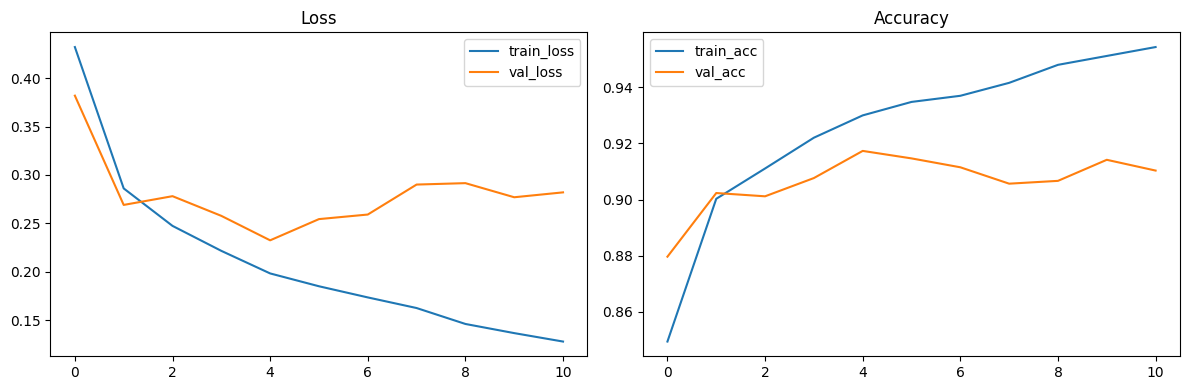

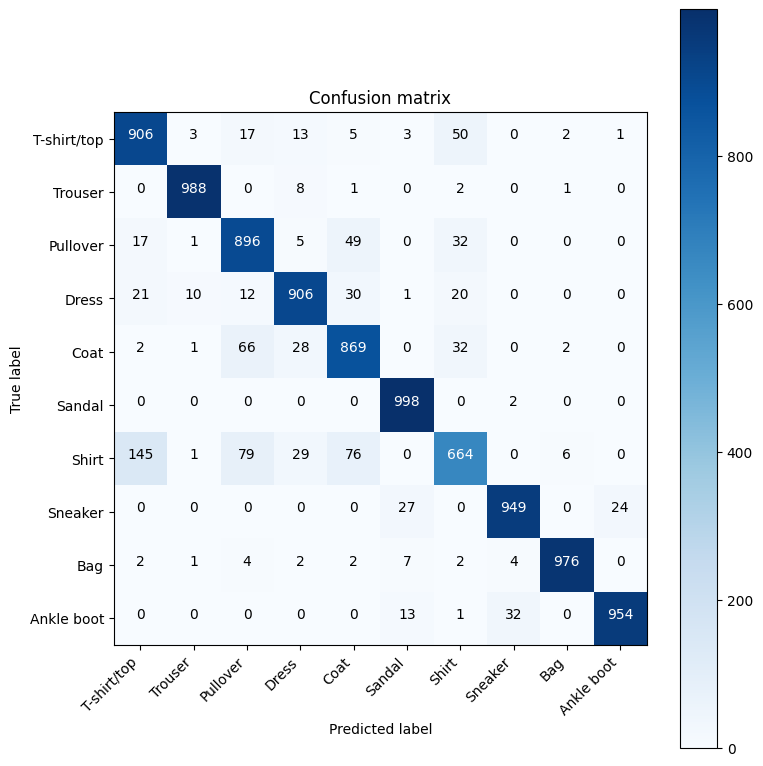

In [22]:
plot_history(history)
plot_confusion_matrix(cm, class_names, normalize=False, title='Confusion matrix')

In [23]:
import pandas as pd
pred_df = pd.DataFrame({'true': y_test, 'pred': y_pred})
pred_csv = os.path.join(MODEL_DIR, 'test_predictions.csv')
pred_df.to_csv(pred_csv, index=False)
print(f"Saved predictions CSV to {pred_csv}")

Saved predictions CSV to model_files/test_predictions.csv
